# Energy Estimator

---

Aditya Marathe

**Aims:**
- Select relevant data which can be used for training / testing.
- Plot a correlation matrix for this data. Can we identify any interesting relationships between parameters?
- Transform the data so that it can be used effectively as training / testing data.
- What is the signal-to-background ratio of the sample? Is there an optimal value which procuces the best results?
- Split into training and testing data.
- Build a model which estimates the energy of a $\nu_\mu$

## Imports

In [2]:
import os
import sys

import pathlib

In [3]:
%matplotlib inline

import dotenv

import h5py
# import dask
# import dask.dataframe as dd
# import dask.array as da
import pandas as pd

import numpy as np
import numpy.typing as npt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import matplotlib as mpl
import matplotlib.pyplot as plt

**Version and hardware**

In [4]:
print(f'Python {sys.version}\n')
print(f'H5Py {h5py.__version__}')
# print(f'Dask {dask.__version__}')
print(f'Pandas {pd.__version__}')
print(f'NumPy {np.__version__}')
print(f'Matplotlib {mpl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

H5Py 3.10.0
Pandas 2.1.2
NumPy 1.26.1
Matplotlib 3.8.1


**Local imports**

In [5]:
sys.path.insert(1, './../')

from initial_analysis import *
from cuts import Cuts

**Setting up the enviornment...*

In [6]:
# The '.env' file contains the directory to the data.
dotenv.load_dotenv();

## 1. Preparing the data

In [7]:
file_dir = pathlib.Path(os.environ['MINI_DATA_DIR'])

df_rename_map = {
    # Cuts (not used for training / testing)
    'numuBasicQuality': 'Cuts.DetectorQuality',
    'numuQuality': 'Cuts.DataQuality',
    'numucontain': 'Cuts.Containment',
    'numu2020pid': 'Cuts.PIDScore',
    'numucosrej': 'Cuts.CosmicRej',
    '3flavourveto': 'Cuts.Veto',
    'numufull': 'Cuts.Full',
    # MC Truth
    'trueEnu': 'MCTruth.ENu',
    # Derived Quant.
    'pmu': 'Derived.PMu',
    'pt': 'Derived.TransPMu',
    'ptp': 'Derived.TransPtoPRatio',
    'recoq2': 'Derived.QSquared',
    # Reconstructed Qant.
    'cosBeamFirst': 'Reconstructed.CosBeamFirst',
    'rec.energy.numu.hadclust.calE': 'Reconstructed.HadClust.CalE',
    'rec.energy.numu.hadclust.nhit': 'Reconstructed.HadClust.NHits',
    'rec.energy.numu.hadtrkE': 'Reconstructed.HadClust.TrackE',
    'rec.energy.numu.lstmmuon': 'Reconstructed.LSTM.EMu',
    'rec.energy.numu.lstmnu': 'Reconstructed.LSTM.ENu',
    # Pre-selection CVN
    'rec.sel.cvnloosepreselptp.cosmicid': 'Selection.PreSelCVN.CosmicID',
    'rec.sel.cvnloosepreselptp.ncid': 'Selection.PreSelCVN.NCID',
    'rec.sel.cvnloosepreselptp.nueid': 'Selection.PreSelCVN.NuEID',
    'rec.sel.cvnloosepreselptp.numuid': 'Selection.PreSelCVN.NuMuID',
    # Selection and PIDs
    'rec.sel.contain.cosbakcell': 'Selection.Cosmic.BackCell',
    'rec.sel.remid.pid': 'Selection.REMID.PID',
    'rec.sel.scann.scpid': 'Selection.SCPID',
    # Time Slice
    'rec.slc.ncontplanes': 'TimeSlice.NContPlanes',
    'rec.slc.nhit': 'TimeSlice.NHits',
    # Reconstructed Tracks
    'rec.trk.kalman.ntracks': 'Track.Kalman.NTracks'
}

In [8]:
def s1_load_dataset(n_events: int = 2_000_000) -> tuple[pd.DataFrame, pd.DataFrame, list[str]]:
    """\
    Loads the first `n_events` of the full dataset.
    """
    required_cols = list(df_rename_map.keys())
    remaining_cols = list(df_rename_map.values())

    with h5py.File(file_dir, 'r') as file:  
        df = pd.DataFrame(data={key:file[key][:n_events] for key in file.keys()})

    # Filter out unwanted cols, and reorder the cols
    df = df[required_cols]

    # Rename the cols
    df.rename(columns=df_rename_map, inplace=True)  # --> Generally want to avoid `inplace
    
    # Apply cuts to the LSTM data
    df['Reconstructed.LSTM.ENu'] = df['Reconstructed.LSTM.ENu'][df['Cuts.Full']]

    # Seperate dataset into cuts data and training/testing data
    df_cuts = df[remaining_cols[:7]].copy()

    df.drop(columns=remaining_cols[:7], inplace=True)

    return df, df_cuts, remaining_cols

In [9]:
def s1_clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """\
    Cleans dataset in preperation for further analysis.
    """
    # Negative energies (Assuming it is not referring to anti-particles!)
    target_cols = [
        'Reconstructed.LSTM.EMu',
        'Reconstructed.HadClust.TrackE',
        'Reconstructed.HadClust.CalE'
    ]

    for col in target_cols:
        condition = df[col] < 0
        df.loc[condition, col] = 0.

    # The PID Scores must be between 0 and 1
    target_cols = [
        'Selection.PreSelCVN.CosmicID',
        'Selection.PreSelCVN.NCID',
        'Selection.PreSelCVN.NuEID',
        'Selection.PreSelCVN.NuMuID'
    ]

    for col in target_cols:
        condition = (df[col] < 0) & (df[col] > 1)
        df.loc[condition, col] = 0.

    # Cos(Theta) must be between 0 and 1?
    # df.loc[df['Reconstructed.CosBeamFirst'] < 0, 'Reconstructed.CosBeamFirst'] = 0.

    return df

In [10]:
df, df_cuts, df_cols = s1_load_dataset()
df = s1_clean_dataset(df)

In [11]:
df.head()

,MCTruth.ENu,Derived.PMu,Derived.TransPMu,Derived.TransPtoPRatio,Derived.QSquared,Reconstructed.CosBeamFirst,Reconstructed.HadClust.CalE,Reconstructed.HadClust.NHits,Reconstructed.HadClust.TrackE,Reconstructed.LSTM.EMu,...,Selection.PreSelCVN.CosmicID,Selection.PreSelCVN.NCID,Selection.PreSelCVN.NuEID,Selection.PreSelCVN.NuMuID,Selection.Cosmic.BackCell,Selection.REMID.PID,Selection.SCPID,TimeSlice.NContPlanes,TimeSlice.NHits,Track.Kalman.NTracks
0,0.000000,0.614776,0.610730,0.993419,0.925479,0.114537,0.000000,0,0.115591,0.623789,...,0.998973,0.000158,0.000026,0.000843,2,0.336538,0.096694,9,41,1
1,0.000000,4.482139,2.527317,0.563864,8.439269,0.825868,0.105311,9,0.007038,4.483384,...,0.995076,0.002641,0.001239,0.001045,-5,0.974734,0.191486,93,309,1
2,0.000000,1.809773,1.473772,0.814341,3.127142,0.580387,3.200025,97,0.000000,1.812855,...,0.999301,0.000512,0.000096,0.000091,3,0.945310,0.132330,57,318,1
3,0.839629,0.700136,0.263741,0.376699,0.099019,0.926336,0.011015,2,0.000000,0.708064,...,0.005731,0.011286,0.000614,0.982368,260,0.936047,0.884369,19,43,1
4,0.000000,0.733093,0.732451,0.999125,1.783101,0.041819,0.272180,15,0.318117,0.740668,...,0.990761,0.007486,0.001203,0.000551,2,0.543133,0.087294,8,47,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 21 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MCTruth.ENu                    float32
 1   Derived.PMu                    float32
 2   Derived.TransPMu               float32
 3   Derived.TransPtoPRatio         float32
 4   Derived.QSquared               float32
 5   Reconstructed.CosBeamFirst     float32
 6   Reconstructed.HadClust.CalE    float32
 7   Reconstructed.HadClust.NHits   uint32 
 8   Reconstructed.HadClust.TrackE  float32
 9   Reconstructed.LSTM.EMu         float32
 10  Reconstructed.LSTM.ENu         float32
 11  Selection.PreSelCVN.CosmicID   float32
 12  Selection.PreSelCVN.NCID       float32
 13  Selection.PreSelCVN.NuEID      float32
 14  Selection.PreSelCVN.NuMuID     float32
 15  Selection.Cosmic.BackCell      int32  
 16  Selection.REMID.PID            float32
 17  Selection.SCPID                float32
 18  Ti

In [13]:
print(df_cols)

['Cuts.DetectorQuality', 'Cuts.DataQuality', 'Cuts.Containment', 'Cuts.PIDScore', 'Cuts.CosmicRej', 'Cuts.Veto', 'Cuts.Full', 'MCTruth.ENu', 'Derived.PMu', 'Derived.TransPMu', 'Derived.TransPtoPRatio', 'Derived.QSquared', 'Reconstructed.CosBeamFirst', 'Reconstructed.HadClust.CalE', 'Reconstructed.HadClust.NHits', 'Reconstructed.HadClust.TrackE', 'Reconstructed.LSTM.EMu', 'Reconstructed.LSTM.ENu', 'Selection.PreSelCVN.CosmicID', 'Selection.PreSelCVN.NCID', 'Selection.PreSelCVN.NuEID', 'Selection.PreSelCVN.NuMuID', 'Selection.Cosmic.BackCell', 'Selection.REMID.PID', 'Selection.SCPID', 'TimeSlice.NContPlanes', 'TimeSlice.NHits', 'Track.Kalman.NTracks']


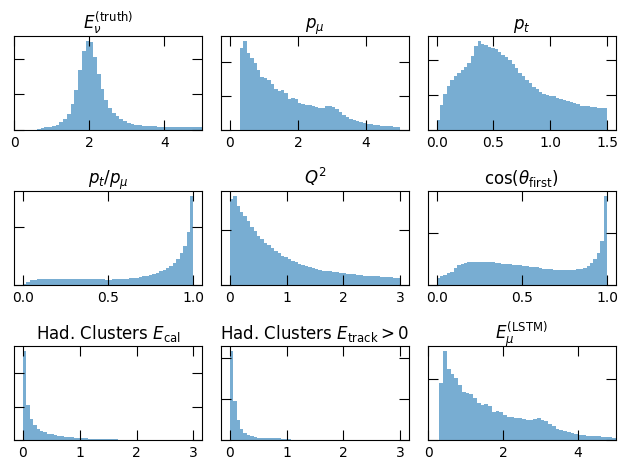

In [14]:
fig, axs = plt.subplots(3, 3)

axs = axs.flatten()

bins_conf = np.linspace(0, 5, 50 + 1)

axs[0].hist(df['MCTruth.ENu'][df['MCTruth.ENu'] > 0], bins=bins_conf, alpha=0.6)
axs[0].set_title(r'$E_\nu^\text{(truth)}$')
axs[0].set_xlim(0, 5)

axs[1].hist(df['Derived.PMu'], bins=bins_conf, alpha=0.6)
axs[1].set_title(r'$p_\mu$')

axs[2].hist(df['Derived.TransPMu'], bins=np.linspace(0, 1.5, 50 + 1), alpha=0.6)
axs[2].set_title(r'$p_t$')

axs[3].hist(df['Derived.TransPtoPRatio'], bins=np.linspace(0, 1, 50 + 1), alpha=0.6)
axs[3].set_title(r'$p_t / p_\mu$')

axs[4].hist(df['Derived.QSquared'], np.linspace(0, 3, 50 + 1), alpha=0.6)
axs[4].set_title(r'$Q^2$')

axs[5].hist(df['Reconstructed.CosBeamFirst'], bins=np.linspace(0, 1, 50 + 1), alpha=0.6)
axs[5].set_title(r'cos($\theta_\text{first}$)')

axs[6].hist(df['Reconstructed.HadClust.CalE'], bins=np.linspace(0, 3, 50 + 1), alpha=0.6)
axs[6].set_title(r'Had. Clusters $E_\text{cal}$')

_key = 'Reconstructed.HadClust.TrackE'
axs[7].hist(df[_key][df[_key] > 0], bins=np.linspace(0, 3, 50 + 1), alpha=0.6)
axs[7].set_title(r'Had. Clusters $E_\text{track} > 0$')

axs[8].hist(df['Reconstructed.LSTM.EMu'], bins=bins_conf, alpha=0.6)
axs[8].set_title(r'$E_\mu^\text{(LSTM)}$')
axs[8].set_xlim(0, 5)

for ax in axs:
    ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
    ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)
    ax.set_yticklabels([])

plt.tight_layout();

In [15]:
# Applying Log() to the data that is right skewed...
right_skewed_data = [
    'Derived.PMu',
    'Derived.QSquared',
    'Reconstructed.HadClust.CalE',
    'Reconstructed.HadClust.TrackE',
    'Reconstructed.LSTM.EMu'
]

temp_df = dict()

for data_key in right_skewed_data:
    # Note: Adding a small number like this to the data is actually very risky
    temp_df[f'Log({data_key})'] = np.log(df[data_key] + 1E-10)

c:\Users\Shrey\OneDrive\Documents\GitHub\msci-project\.venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


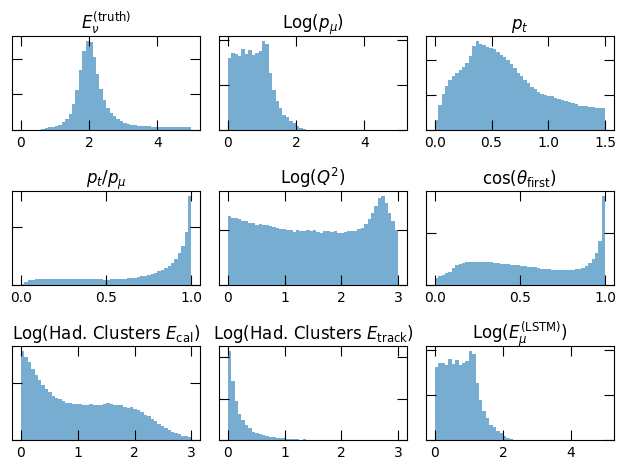

In [16]:
fig, axs = plt.subplots(3, 3)

axs = axs.flatten()

bins_conf = np.linspace(0, 5, 50 + 1)

axs[0].hist(df['MCTruth.ENu'][df['MCTruth.ENu'] > 0], bins=bins_conf, alpha=0.6)
axs[0].set_title(r'$E_\nu^\text{(truth)}$')

axs[1].hist(temp_df['Log(Derived.PMu)'], bins=bins_conf, alpha=0.6)
axs[1].set_title(r'Log($p_\mu$)')

axs[2].hist(df['Derived.TransPMu'], bins=np.linspace(0, 1.5, 50 + 1), alpha=0.6)
axs[2].set_title(r'$p_t$')

axs[3].hist(df['Derived.TransPtoPRatio'], bins=np.linspace(0, 1, 50 + 1), alpha=0.6)
axs[3].set_title(r'$p_t / p_\mu$')

axs[4].hist(temp_df['Log(Derived.QSquared)'], np.linspace(0, 3, 50 + 1), alpha=0.6)
axs[4].set_title(r'Log($Q^2$)')

axs[5].hist(df['Reconstructed.CosBeamFirst'], bins=np.linspace(0, 1, 50 + 1), alpha=0.6)
axs[5].set_title(r'cos($\theta_\text{first}$)')

axs[6].hist(temp_df['Log(Reconstructed.HadClust.CalE)'], bins=np.linspace(0, 3, 50 + 1), alpha=0.6)
axs[6].set_title(r'Log(Had. Clusters $E_\text{cal}$)')

_key = 'Log(Reconstructed.HadClust.TrackE)'
axs[7].hist(temp_df[_key][temp_df[_key] > 0], bins=np.linspace(0, 3, 50 + 1), alpha=0.6)
axs[7].set_title(r'Log(Had. Clusters $E_\text{track})$')

axs[8].hist(temp_df['Log(Reconstructed.LSTM.EMu)'], bins=bins_conf, alpha=0.6)
axs[8].set_title(r'Log($E_\mu^\text{(LSTM)}$)')

for ax in axs:
    ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
    ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)
    ax.set_yticklabels([])

plt.tight_layout();

- The log distribution of $p_\mu$ is very similar to the log distribution of $E_\mu^\text{(LSTM)}$ since it is derived from the energy-momentum relation ($E^2 = p^2 + m^2$) and for high-energies $E^2 \approx p^2$.
- The distribution of $p_t / p_\mu$ (or $\text{sin}(\theta_\text{first})$) is also quite similar to that of $\text{cos}(\theta_\text{first})$, again, becasue it was derived from this quantity.

In [17]:
del temp_df

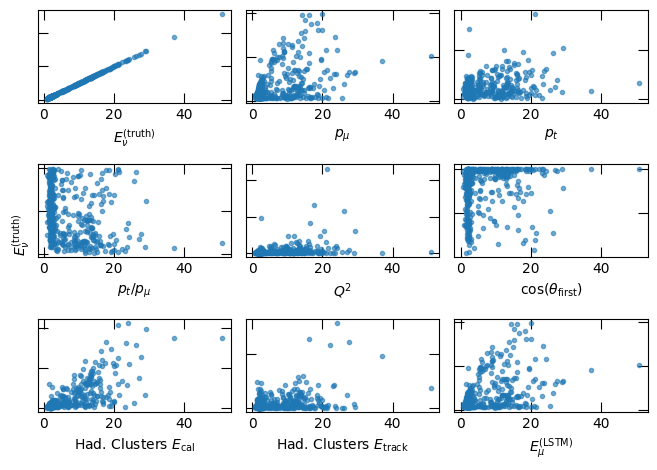

In [18]:
fig, axs = plt.subplots(3, 3)

axs = axs.flatten()

data_crop = 500

axs[0].plot(
    df['MCTruth.ENu'][df['MCTruth.ENu'] > 0][:data_crop], 
    df['MCTruth.ENu'][df['MCTruth.ENu'] > 0][:data_crop],
    '.', 
    alpha=0.6
)
axs[0].set_xlabel(r'$E_\nu^\text{(truth)}$')

axs[1].plot(
    df['MCTruth.ENu'][df['MCTruth.ENu'] > 0][:data_crop], 
    df['Derived.PMu'][df['MCTruth.ENu'] > 0][:data_crop],
    '.', 
    alpha=0.6
)
axs[1].set_xlabel(r'$p_\mu$')

axs[2].plot(
    df['MCTruth.ENu'][df['MCTruth.ENu'] > 0][:data_crop], 
    df['Derived.TransPMu'][df['MCTruth.ENu'] > 0][:data_crop],
    '.', 
    alpha=0.6
)
axs[2].set_xlabel(r'$p_t$')

axs[3].plot(
    df['MCTruth.ENu'][df['MCTruth.ENu'] > 0][:data_crop], 
    df['Derived.TransPtoPRatio'][df['MCTruth.ENu'] > 0][:data_crop],
    '.', 
    alpha=0.6
)
axs[3].set_xlabel(r'$p_t / p_\mu$')

axs[4].plot(
    df['MCTruth.ENu'][df['MCTruth.ENu'] > 0][:data_crop], 
    df['Derived.QSquared'][df['MCTruth.ENu'] > 0][:data_crop],
    '.', 
    alpha=0.6
)
axs[4].set_xlabel(r'$Q^2$')

axs[5].plot(
    df['MCTruth.ENu'][df['MCTruth.ENu'] > 0][:data_crop], 
    df['Reconstructed.CosBeamFirst'][df['MCTruth.ENu'] > 0][:data_crop],
    '.', 
    alpha=0.6
)
axs[5].set_xlabel(r'cos($\theta_\text{first}$)')

axs[6].plot(
    df['MCTruth.ENu'][df['MCTruth.ENu'] > 0][:data_crop], 
    df['Reconstructed.HadClust.CalE'][df['MCTruth.ENu'] > 0][:data_crop],
    '.', 
    alpha=0.6
)
axs[6].set_xlabel(r'Had. Clusters $E_\text{cal}$')

_key = 'Reconstructed.HadClust.TrackE'
axs[7].plot(
    df['MCTruth.ENu'][df['MCTruth.ENu'] > 0][:data_crop], 
    df[_key][df['MCTruth.ENu'] > 0][:data_crop],
    '.',
    alpha=0.6
)
axs[7].set_xlabel(r'Had. Clusters $E_\text{track}$')

axs[8].plot(
    df['MCTruth.ENu'][df['MCTruth.ENu'] > 0][:data_crop], 
    df['Reconstructed.LSTM.EMu'][df['MCTruth.ENu'] > 0][:data_crop], 
    '.',
    alpha=0.6
)
axs[8].set_xlabel(r'$E_\mu^\text{(LSTM)}$')

for ax in axs:
    ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
    ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)
    ax.set_yticklabels([])

fig.text(-0.02, 0.5, r'$E_\nu^\text{(truth)}$', va='center', rotation='vertical')

plt.tight_layout();

Note: The plots above use $E_\nu^\text{truth}$ for y-axis variable. No pattern here, but a small (but significant) positive correlation to $p_\mu$ (hence, to $p_t$ and $E_\mu^\text{(LSTM)}$) and $E_\text{cal}$.

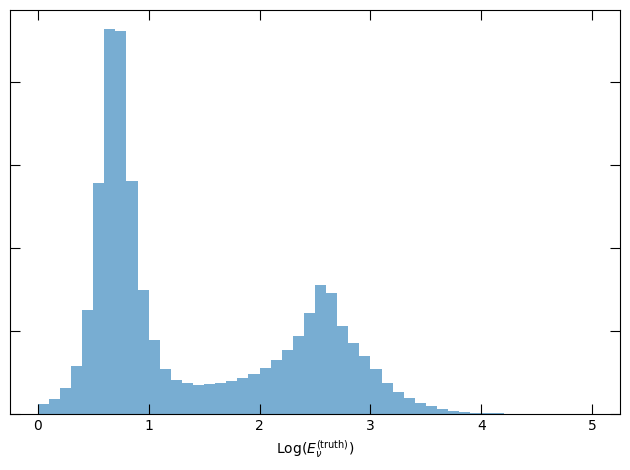

In [19]:
fig, ax = plt.subplots()

bins_conf = np.linspace(0, 5, 50 + 1)

ax.hist(np.log(df['MCTruth.ENu'][df['MCTruth.ENu'] > 0]), bins=bins_conf, alpha=0.6)
ax.set_xlabel(r'Log($E_\nu^\text{(truth)}$)')
# ax.set_xlim(0, 5)

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)
ax.set_yticklabels([])

plt.tight_layout();

Plotting Log($E_\nu^\text{(truth)}$) reduces the range of the distribution from between 0-30 GeV to 0-5 GeV. This can benefitial becasue it is easier to train the model using this data. The distribution of $E_\nu^\text{(truth)}$ is bimodal, with the second peak at very high energies (What are these high energy events?).

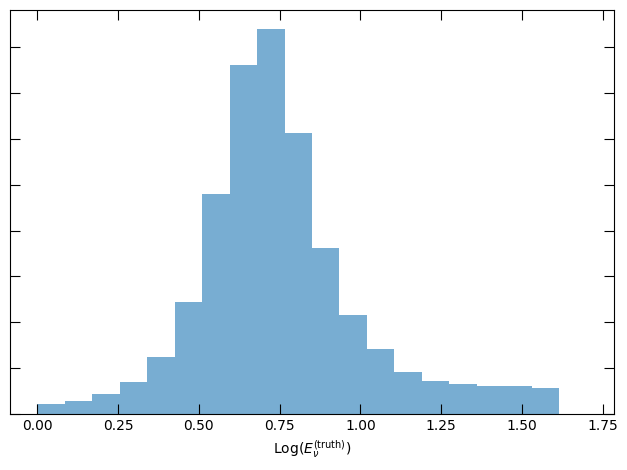

In [34]:
fig, ax = plt.subplots()

bins_conf = np.linspace(0, 1.7, 20 + 1)

ax.hist(
    np.log(df['MCTruth.ENu'][(df['MCTruth.ENu'] > 0) & (df['MCTruth.ENu'] < 5)]),  
    bins=bins_conf, 
    alpha=0.6
)
ax.set_xlabel(r'Log($E_\nu^\text{(truth)}$)')
# ax.set_xlim(0, 5)

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)
ax.set_yticklabels([])

plt.tight_layout();

In [19]:
corr_matrix = df.corr()

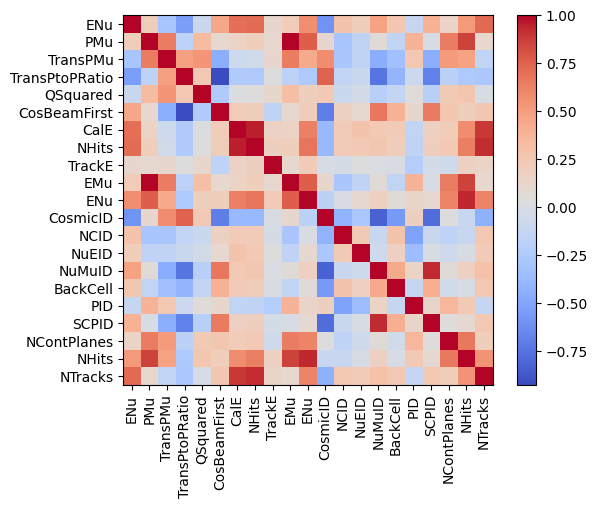

In [20]:
fig, ax = plt.subplots() # figsize=(10, 8))

ref = ax.imshow(corr_matrix, cmap='coolwarm')

fig.colorbar(ref)

labels = [col_name.split('.')[-1] for col_name in df.columns]

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

del corr_matrix;

$E_\nu^\text{(truth)}$ has positive correlation with the following parameters:
- Hadronic cluster $E_\text{cal}$
- Number of hits in hadronic clusters
- The number of tracks (Kalman algorithm)
- (and $\nu_\mu$ ID)

and a negative correlation to:
- $p_t / p$ (and $p_t$)
- $Q^2$
- (and Cosmic ID, of course)

Hence, these parameters are the most vital for producing our energy predictions. *Note*: Can they be combined into one (unitless) parameter?

There are some nice things we can spot from the other parameters. For example, $p_\mu$ has a strong positive correlation with $E_\mu^\text{(LSTM)}$ which makes sense. Also, $\text{cos}(\theta_\text{first})$ has a strong negative correlation with the $p_t / p$ (which also makes sense) and a slight negative correlation with Cosmic ID. From this, we can infer that cosmic events are those that have a small $\text{cos}(\theta_\text{first})$ or a large $p_t / p$. The opposite is true for $\nu_\mu$ ID.

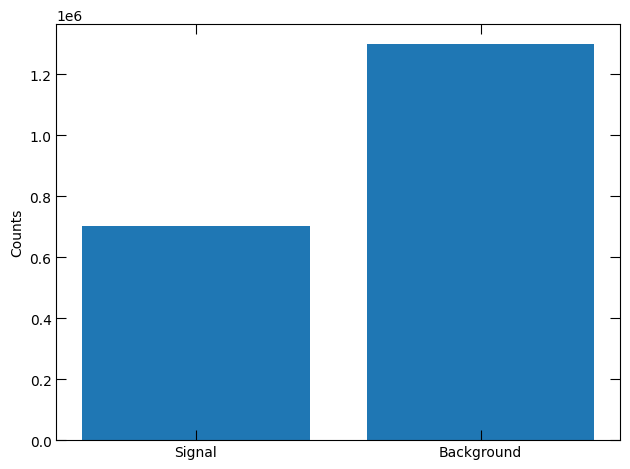

In [21]:
fig, ax = plt.subplots()

total = len(df['MCTruth.ENu'])
signal = len(df['MCTruth.ENu'][df['MCTruth.ENu'] > 0])

ax.bar(['Signal', 'Background'], [signal, total - signal])

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_ylabel('Counts')

plt.tight_layout();

Unequal counts could result in unwanted baises in our model. In this case, our sample has more background events than signal events (roughly twice as many!).

Refer to: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

## 2. First Model

In [74]:
s2_numu_cuts = Cuts.init_nova_cuts()

### 2.1 Attempt 1

This is the simplest model which will consist of several dense layers. We will not be transforming the data in any way (other than the initial cleaning) and no cuts will be applied.

In [22]:
def s2_make_and_compile(
        input_shape: tuple[int, ...],
        learning_rate: float = 1E-3
    ) -> keras.Sequential:
    """
    """
    model = keras.models.Sequential(
        layers=[
            keras.layers.InputLayer(input_shape=input_shape),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(units=128, activation=keras.activations.relu),
            keras.layers.Dense(units=64, activation=keras.activations.relu),
            keras.layers.Dropout(rate=0.2),  # --> Added later to prevent overfitting
            keras.layers.Dense(units=32, activation=keras.activations.relu),
            keras.layers.Dense(units=16, activation=keras.activations.relu),
            keras.layers.Dropout(rate=0.2),
            keras.layers.Dense(units=1, activation=keras.activations.linear)
        ],
        name='sequential_1'
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.mean_squared_error,
        metrics=[
            # keras.metrics.Accuracy(),
            keras.metrics.MeanSquaredError()
        ]
    )

    return model

In [23]:
def s2_ttv_split(
        df: pd.DataFrame,
        train_percent: float = 0.9,
        random_state: int | None = None
    ) -> dict[str, dict[str, tf.Tensor]]:
    if train_percent > 1.:
        raise ValueError('The training data percentage must be less than 100%.')

    # Shuffle data frame and reset indices
    df_new = df.sample(frac=1, random_state=random_state)
    df_new = df_new.reset_index(drop=True)

    df_signal = df_new[df_new['MCTruth.ENu'] > 0]
    # Non-neutrino events are our background in this case
    df_background = df_new[df_new['MCTruth.ENu'] == 0]
    
    # Split
    n_signal = len(df_signal)
    n_background = len(df_background)

    n_train_signal = int(n_signal * train_percent)
    n_train_background = int(n_background * train_percent)

    n_test_val_signal = (n_signal - n_train_signal) // 2
    n_test_val_background = (n_background - n_train_background) // 2
    
    df_train_signal_x = df_signal.iloc[:n_train_signal]
    df_test_signal_x = df_signal.iloc[n_train_signal:n_train_signal + n_test_val_signal]
    df_val_signal_x = df_signal.iloc[n_train_signal + n_test_val_signal:]

    df_train_background_x = df_background.iloc[:n_train_background]
    df_test_background_x = df_background.iloc[n_train_background:n_train_background + n_test_val_background]
    df_val_background_x = df_background.iloc[n_train_background + n_test_val_background:]

    # Y-data
    df_train_y =  tf.constant(
        pd.concat(
            [df_train_signal_x.pop('MCTruth.ENu'),
            df_train_background_x.pop('MCTruth.ENu')], 
            ignore_index=True
        ),
        dtype=tf.float32
    )
    df_test_y =  tf.constant(
        pd.concat(
            [df_test_signal_x.pop('MCTruth.ENu'),
            df_test_background_x.pop('MCTruth.ENu')], 
            ignore_index=True
        ),
        dtype=tf.float32
    )
    df_val_y = tf.constant(
        pd.concat(
            [df_val_signal_x.pop('MCTruth.ENu'),
            df_val_background_x.pop('MCTruth.ENu')], 
            ignore_index=True
        ),
        dtype=tf.float32
    )
    
    # X-data
    df_train_x =  tf.constant(
        pd.concat(
            [df_train_signal_x,
            df_train_background_x], 
            ignore_index=True
        ),
        dtype=tf.float32
    )
    df_test_x =  tf.constant(
        pd.concat(
            [df_test_signal_x,
            df_test_background_x], 
            ignore_index=True
        ),
        dtype=tf.float32
    )
    df_val_x = tf.constant(
        pd.concat(
            [df_val_signal_x,
            df_val_background_x], 
            ignore_index=True
        ),
        dtype=tf.float32
    )

    return {
        'Train': {
            'X': df_train_x, 
            'Y': df_train_y
        },
        'Test': {
            'X': df_test_x, 
            'Y': df_test_y
        },
        'Val': {
            'X': df_val_x, 
            'Y': df_val_y
        }
    }

In [24]:
ttv_data = s2_ttv_split(df=df, random_state=42)

print(f"{ttv_data['Train']['X'].shape = }")
print(f"{ttv_data['Train']['Y'].shape = }")
train_y = ttv_data['Train']['Y']
percent_signal = train_y[train_y > 0].shape[0] / train_y.shape[0]
print(f'Signal/Total = {percent_signal:0.2f}\n')

print(f"{ttv_data['Test']['X'].shape = }")
print(f"{ttv_data['Test']['Y'].shape = }")
test_y = ttv_data['Train']['Y']
percent_signal = test_y[test_y > 0].shape[0] / test_y.shape[0]
print(f'Signal/Total = {percent_signal:0.2f}\n')

print(f"{ttv_data['Val']['X'].shape = }")
print(f"{ttv_data['Val']['Y'].shape = }")
val_y = ttv_data['Train']['Y']
percent_signal = val_y[val_y > 0].shape[0] / val_y.shape[0]
print(f'Signal/Total = {percent_signal:0.2f}\n')

ttv_data['Train']['X'].shape = TensorShape([1799999, 20])
ttv_data['Train']['Y'].shape = TensorShape([1799999])
Signal/Total = 0.35

ttv_data['Test']['X'].shape = TensorShape([100000, 20])
ttv_data['Test']['Y'].shape = TensorShape([100000])
Signal/Total = 0.35

ttv_data['Val']['X'].shape = TensorShape([100001, 20])
ttv_data['Val']['Y'].shape = TensorShape([100001])
Signal/Total = 0.35



In [25]:
# s2_simple_model = s2_make_and_compile(input_shape=(19,))
# s2_simple_model.summary()

In [26]:
# s2_simple_model_output = s2_simple_model.fit(
#     x=ttv_data['Train']['X'], y=ttv_data['Train']['Y'],
#     validation_data=(ttv_data['Val']['X'], ttv_data['Val']['Y']),
#     epochs=10,
#     callbacks=[
#         keras.callbacks.EarlyStopping()
#     ]
# )

The `EarlyStopping` stopped the model training. Training using this dataset/model is not going to be an effective approach, hence we try to change our data by increasing the ratio of $\nu_\mu$ events in our training dataset. Currently, the training data contains 35% signal events, we must increase this to (1) make it equal to the number of background and then (2) we can try using more signal events than background. 

### 2.2 Attepmt 2

In [41]:
config = {
    # Cuts applied to the initial data
    'Cuts': [
        'Cuts.DetectorQuality',
        'Cuts.DataQuality'
    ],

    # `DataFrame` columns to produce the training, testing and validation 
    'XData': [
        # 'Derived.PMu',
        # 'Derived.TransPMu',
        'Derived.TransPtoPRatio',
        # 'Derived.QSquared',
        'Reconstructed.CosBeamFirst',
        'Reconstructed.HadClust.CalE',
        'Reconstructed.HadClust.NHits',
        # 'Reconstructed.HadClust.TrackE',
        # 'Reconstructed.LSTM.EMu',
        'Selection.PreSelCVN.CosmicID',
        # 'Selection.PreSelCVN.NCID',
        # 'Selection.PreSelCVN.NuEID',
        'Selection.PreSelCVN.NuMuID',
        # 'Selection.Cosmic.BackCell',
        # 'Selection.REMID.PID',
        # 'Selection.SCPID',
        # 'TimeSlice.NContPlanes',
        'TimeSlice.NHits',
        'Track.Kalman.NTracks'
    ],
    'YData': [
        'MCTruth.ENu'
    ],

    # Used to compare with our model...
    'ComparisonData': [
        'Reconstructed.LSTM.ENu'
    ],

    # Hyperprameters
    'HyperParameters': {
        # Compilation stuff
        'LearningRate': 1E-3,
        'BatchSize': 100,
        'Epochs': 10,
        # Model stuff
        'Dropout 1': 0.5
    }
}

model_architecture = {
    'Sequential 1': [
        keras.layers.InputLayer(input_shape=(len(config['XData']),)),
        keras.layers.Dense(units=32, activation=keras.activations.relu),
        keras.layers.Dense(units=16, activation=keras.activations.relu),
        # To prevent overfitting
        keras.layers.Dropout(rate=config['HyperParameters']['Dropout 1']),  
        keras.layers.Dense(units=32, activation=keras.activations.relu),
        keras.layers.Dense(units=16, activation=keras.activations.relu),
        keras.layers.Dense(units=1, activation=keras.activations.linear)
    ]
}

In [ ]:
def log_config(config_file: str | pathlib.Path = '../logs') -> None:
    ...


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
            self, 
            df: pd.DataFrame,
            batch_size: int,
            shuffle: bool = True,
            random_state: int | None = None
        ) -> None:
        super().__init__()

        self.df = df.copy()
        self.random_state = random_state

        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Shuffle the data
        self.on_epoch_end()

        self.len = len(self.df)

        # TODO: Data Cleaning

        # TODO: Data Transformation --> Add this to the __getitem__ method?

    def on_epoch_end(self) -> None:
        self.df = self.df.sample(frac=1, random_state=self.random_state)
        self.df.reset_index(drop=True, inplace=True)

    def __getitem__(self, index: int) -> tuple[pd.DataFrame, pd.Series]:
        # Gets data by batch
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size

        x_data = self.df.iloc[start_index:end_index, :]
        y_data = x_data.pop('MCTruth.ENu')

        return x_data, y_data

    def __len__(self):
        # Number of batches
        return int(np.ceil(len(self.df) / float(self.batch_size)))

In [46]:
def s2_make_and_compile(
        input_shape: tuple[int, ...],
        learning_rate: float = 1E-3
    ) -> keras.Sequential:
    """
    """
    model = keras.models.Sequential(
        layers=[
            keras.layers.InputLayer(input_shape=input_shape),
            keras.layers.Dense(units=32, activation=keras.activations.relu),
            keras.layers.Dense(units=16, activation=keras.activations.relu),
            keras.layers.Dropout(rate=0.5),  # --> Added later to prevent overfitting
            keras.layers.Dense(units=32, activation=keras.activations.relu),
            keras.layers.Dense(units=16, activation=keras.activations.relu),
            keras.layers.Dense(units=1, activation=keras.activations.linear)
        ],
        name='sequential_1'
    )

    # Different optimizers that can be used:
    # optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        # Loss for regression tasks
        loss=keras.losses.mean_squared_error,
        metrics=[
            # keras.metrics.Accuracy(),
            keras.metrics.MeanSquaredError(),
            keras.metrics.MeanAbsoluteError()
        ]
    )

    return model

In [43]:
def s2_ttv_split(
        df: pd.DataFrame,
        train_percent: float = 0.9,
        random_state: int | None = None
    ) -> dict[str, dict[str, pd.DataFrame]]:
    if train_percent > 1.:
        raise ValueError('The training data percentage must be less than 100%.')

    # Shuffle data frame and reset indices
    df_new = df.sample(frac=1, random_state=random_state)
    df_new = df_new.reset_index(drop=True)

    # Get LSTM data
    df_lstm: pd.Series | None = None
    if 'Reconstructed.LSTM.ENu' in df.columns:
        df_lstm = df_new.pop('Reconstructed.LSTM.ENu')

    df_signal = df_new[df_new['MCTruth.ENu'] > 0]
    # Non-neutrino events are our background in this case
    df_background = df_new[df_new['MCTruth.ENu'] == 0]

    # Change the 0 GeV true energy to -10 GeV to make non-signal events clearer
    df_background.loc[:, 'MCTruth.ENu'] = -10
    
    # Split
    n_signal = len(df_signal)
    n_train_signal = int(n_signal * train_percent)
    n_test_val_signal = (n_signal - n_train_signal) // 2
    
    df_train_signal_x = df_signal.iloc[:n_train_signal]
    df_test_signal_x = df_signal.iloc[n_train_signal:n_train_signal + n_test_val_signal]
    df_val_signal_x = df_signal.iloc[n_train_signal + n_test_val_signal:]
    
    # n_signal = n_signal // 3
    # n_train_signal = n_train_signal // 3
    # n_test_val_signal = n_test_val_signal // 3

    # TODO: Account for cases where n_signal > n_background in the initial df

    df_train_lstm = pd.Series(data=[])
    df_test_lstm = pd.Series(data=[])
    df_val_lstm = pd.Series(data=[])

    if df_lstm is not None:
        df_train_lstm = df_lstm.iloc[:n_train_signal]
        df_test_lstm = df_lstm.iloc[n_train_signal:n_train_signal + n_test_val_signal]
        df_val_lstm = df_lstm.iloc[n_train_signal + n_test_val_signal:]

    df_train_background_x = df_background.iloc[:n_train_signal]
    df_test_background_x = df_background.iloc[n_train_signal:n_train_signal + n_test_val_signal]
    df_val_background_x = df_background.iloc[n_train_signal + n_test_val_signal:]

    # Y-data
    df_train_y = pd.concat(
        [df_train_signal_x.pop('MCTruth.ENu'),
        df_train_background_x.pop('MCTruth.ENu')], 
        ignore_index=True
    )
    df_test_y = pd.concat(
        [df_test_signal_x.pop('MCTruth.ENu'),
        df_test_background_x.pop('MCTruth.ENu')], 
        ignore_index=True
    )
    df_val_y = pd.concat(
        [df_val_signal_x.pop('MCTruth.ENu'),
        df_val_background_x.pop('MCTruth.ENu')], 
        ignore_index=True
    )
    
    # X-data
    df_train_x = pd.concat(
        [df_train_signal_x,
        df_train_background_x], 
        ignore_index=True
    )
    df_test_x = pd.concat(
        [df_test_signal_x,
        df_test_background_x], 
        ignore_index=True
    )
    df_val_x = pd.concat(
        [df_val_signal_x,
        df_val_background_x], 
        ignore_index=True
    )

    return {
        'Train': {
            'X': df_train_x, 
            'Y': df_train_y,
            'LSTM': df_train_lstm
        },
        'Test': {
            'X': df_test_x, 
            'Y': df_test_y,
            'LSTM': df_test_lstm
        },
        'Val': {
            'X': df_val_x, 
            'Y': df_val_y,
            'LSTM': df_val_lstm
        }
    }

In [44]:
ttv_data = s2_ttv_split(df=df, random_state=42)

print(f"{ttv_data['Train']['X'].shape = }")
print(f"{ttv_data['Train']['Y'].shape = }")
train_y = ttv_data['Train']['Y']
percent_signal = train_y[train_y > 0].shape[0] / train_y.shape[0]
print(f'Signal/Total = {percent_signal:0.2f}\n')

print(f"{ttv_data['Test']['X'].shape = }")
print(f"{ttv_data['Test']['Y'].shape = }")
test_y = ttv_data['Train']['Y']
percent_signal = test_y[test_y > 0].shape[0] / test_y.shape[0]
print(f'Signal/Total = {percent_signal:0.2f}\n')

print(f"{ttv_data['Val']['X'].shape = }")
print(f"{ttv_data['Val']['Y'].shape = }")
val_y = ttv_data['Train']['Y']
percent_signal = val_y[val_y > 0].shape[0] / val_y.shape[0]
print(f'Signal/Total = {percent_signal:0.2f}\n')

ttv_data['Train']['X'].shape = (1262798, 19)
ttv_data['Train']['Y'].shape = (1262798,)
Signal/Total = 0.50

ttv_data['Test']['X'].shape = (70156, 19)
ttv_data['Test']['Y'].shape = (70156,)
Signal/Total = 0.50

ttv_data['Val']['X'].shape = (667046, 19)
ttv_data['Val']['Y'].shape = (667046,)
Signal/Total = 0.50



In [49]:
s2_simple_model = s2_make_and_compile(input_shape=(19,))
s2_simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                640       
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                544       
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-traina

In [50]:
EPOCHS = 10

In [51]:
s2_simple_model_output = s2_simple_model.fit(
    x=ttv_data['Train']['X'], y=ttv_data['Train']['Y'],
    validation_data=(ttv_data['Val']['X'], ttv_data['Val']['Y']),
    epochs=EPOCHS,
    callbacks=[
        # `patience = 2` leads to some funny behaviour when the val_loss oscillates every epoch XD
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Epoch 1/10


39463/39463 [==============================] - 223s 6ms/step - loss: 13.5161 - mean_squared_error: 13.5161 - mean_absolute_error: 1.7666 - val_loss: 3.0900 - val_mean_squared_error: 3.0900 - val_mean_absolute_error: 0.3883
Epoch 2/10
39463/39463 [==============================] - 209s 5ms/step - loss: 12.5239 - mean_squared_error: 12.5239 - mean_absolute_error: 1.4081 - val_loss: 3.1215 - val_mean_squared_error: 3.1215 - val_mean_absolute_error: 0.3765
Epoch 3/10
39463/39463 [==============================] - 208s 5ms/step - loss: 10.1395 - mean_squared_error: 10.1395 - mean_absolute_error: 1.3499 - val_loss: 2.7153 - val_mean_squared_error: 2.7153 - val_mean_absolute_error: 0.3522
Epoch 4/10
39463/39463 [==============================] - 206s 5ms/step - loss: 9.7382 - mean_squared_error: 9.7382 - mean_absolute_error: 1.3249 - val_loss: 3.1834 - val_mean_squared_error: 3.1834 - val_mean_absolute_error: 0.4503
Epoch 5/10
39463/39463 [==============================] - 207s 5ms/step - los

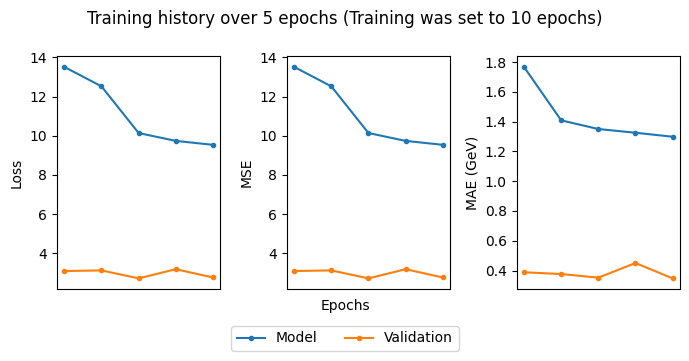

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(7, 3))

axs = axs.flatten()

actual_epochs = range(1, len(s2_simple_model_output.history['loss']) + 1)

axs[0].plot(actual_epochs, s2_simple_model_output.history['loss'], '.-')
axs[0].plot(actual_epochs, s2_simple_model_output.history['val_loss'], '.-')
axs[0].set_ylabel('Loss')

axs[1].plot(actual_epochs, s2_simple_model_output.history['mean_squared_error'], '.-')
axs[1].plot(actual_epochs, s2_simple_model_output.history['val_mean_squared_error'], '.-')
axs[1].set_ylabel('MSE')

axs[2].plot(actual_epochs, s2_simple_model_output.history['mean_absolute_error'], '.-')
axs[2].plot(actual_epochs, s2_simple_model_output.history['val_mean_absolute_error'], '.-')
axs[2].set_ylabel('MAE (GeV)')

for ax in axs:
    ax.set_xticks([])

fig.text(0.5, -0.02, 'Epochs', ha='center')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, labels=['Model', 'Validation'])

fig.suptitle(f'Training history over {len(actual_epochs)} epochs (Training was set to {EPOCHS} epochs)')

plt.tight_layout()

In [58]:
s2_model_pred = s2_simple_model.predict(ttv_data['Test']['X'])

2193/2193 [==============================] - 6s 3ms/step


In [59]:
model_n_background = len(s2_model_pred[s2_model_pred < 0])
truth_n_background = len(ttv_data['Test']['Y'][ttv_data['Test']['Y'] < 0])

print(f'Model {model_n_background}, Truth {truth_n_background}')

if model_n_background <= truth_n_background:
    warn('The model is predicitng less or an equal number of background events.')
else:
    # This is good because we would rather overestimate background events than underestimate them!
    print('Model is predicting more background events.')

Model 35765, Truth 35078
Model is predicting more background events.


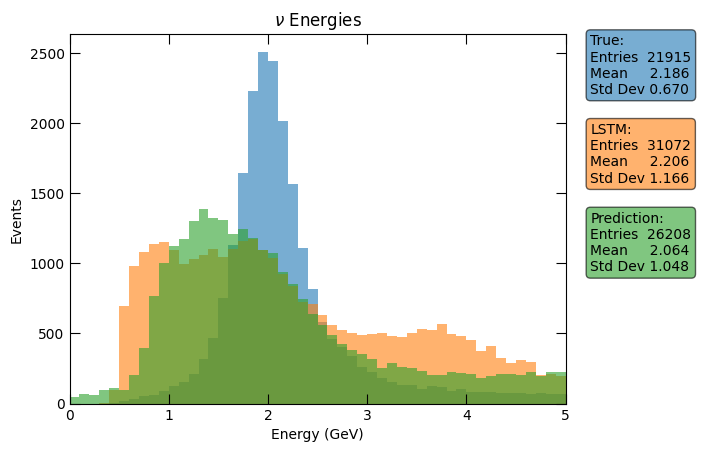

In [60]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 50 + 1)

*_, bc = ax.hist(ttv_data['Test']['Y'], bins=bins_conf, alpha=0.6)
plot_info(ttv_data['Test']['Y'][(ttv_data['Test']['Y'] > 0) & (ttv_data['Test']['Y'] < 5)], bc, 'True')

*_, bc = ax.hist(ttv_data['Test']['LSTM'], bins=bins_conf, alpha=0.6)
plot_info(ttv_data['Test']['LSTM'][(ttv_data['Test']['LSTM'] > 0) & (ttv_data['Test']['LSTM'] < 5)], bc, 'LSTM')

*_, bc = ax.hist(s2_model_pred, bins=bins_conf, alpha=0.6)
plot_info(s2_model_pred[(s2_model_pred > 0) & (s2_model_pred < 5)], bc, 'Prediction')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
# ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

ax.set_title(r'$\nu$ Energies')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


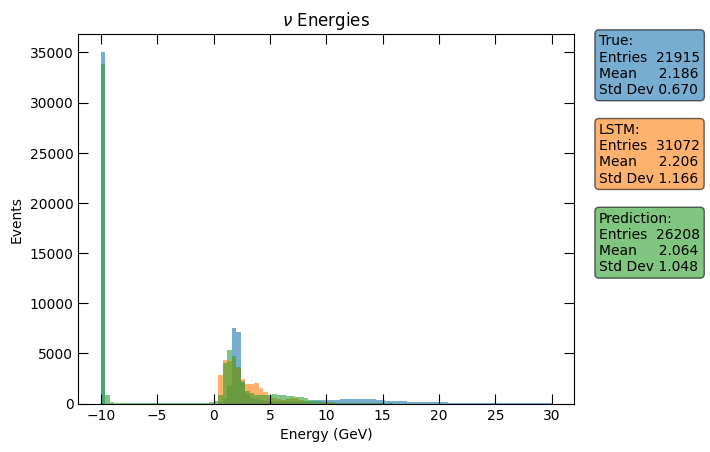

In [61]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(-10, 30, 100 + 1)

*_, bc = ax.hist(ttv_data['Test']['Y'], bins=bins_conf, alpha=0.6)
plot_info(ttv_data['Test']['Y'][(ttv_data['Test']['Y'] > 0) & (ttv_data['Test']['Y'] < 5)], bc, 'True')

*_, bc = ax.hist(ttv_data['Test']['LSTM'], bins=bins_conf, alpha=0.6)
plot_info(ttv_data['Test']['LSTM'][(ttv_data['Test']['LSTM'] > 0) & (ttv_data['Test']['LSTM'] < 5)], bc, 'LSTM')

*_, bc = ax.hist(s2_model_pred, bins=bins_conf, alpha=0.6)
plot_info(s2_model_pred[(s2_model_pred > 0) & (s2_model_pred < 5)], bc, 'Prediction')

# ax.set_yscale('log')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

# ax.set_xlim(-10, 10)

ax.set_title(r'$\nu$ Energies')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


In [87]:
if 'MCTruth.ENu' in df_big_test:
    df_big_truth= df_big_test.pop('MCTruth.ENu')

if 'Reconstructed.LSTM.ENu' in df_big_test:
    df_big_lstm = df_big_test.pop('Reconstructed.LSTM.ENu')

df_big_test.head()

,Derived.PMu,Derived.TransPMu,Derived.TransPtoPRatio,Derived.QSquared,Reconstructed.CosBeamFirst,Reconstructed.HadClust.CalE,Reconstructed.HadClust.NHits,Reconstructed.HadClust.TrackE,Reconstructed.LSTM.EMu,Selection.PreSelCVN.CosmicID,Selection.PreSelCVN.NCID,Selection.PreSelCVN.NuEID,Selection.PreSelCVN.NuMuID,Selection.Cosmic.BackCell,Selection.REMID.PID,Selection.SCPID,TimeSlice.NContPlanes,TimeSlice.NHits,Track.Kalman.NTracks
0,0.614776,0.610730,0.993419,0.925479,0.114537,0.000000,0,0.115591,0.623789,0.998973,0.000158,0.000026,0.000843,2,0.336538,0.096694,9,41,1
1,4.482139,2.527317,0.563864,8.439269,0.825868,0.105311,9,0.007038,4.483384,0.995076,0.002641,0.001239,0.001045,-5,0.974734,0.191486,93,309,1
2,1.809773,1.473772,0.814341,3.127142,0.580387,3.200025,97,0.000000,1.812855,0.999301,0.000512,0.000096,0.000091,3,0.945310,0.132330,57,318,1
3,0.700136,0.263741,0.376699,0.099019,0.926336,0.011015,2,0.000000,0.708064,0.005731,0.011286,0.000614,0.982368,260,0.936047,0.884369,19,43,1
4,0.733093,0.732451,0.999125,1.783101,0.041819,0.272180,15,0.318117,0.740668,0.990761,0.007486,0.001203,0.000551,2,0.543133,0.087294,8,47,1


In [88]:
s2_model_big_pred = s2_simple_model.predict(df_big_test)

125000/125000 [==============================] - 367s 3ms/step


In [89]:
# Save data to pickle
import pickle

with open('./model_1_big_pred.pkl', 'wb') as f:
    pickle.dump(s2_model_big_pred, f)

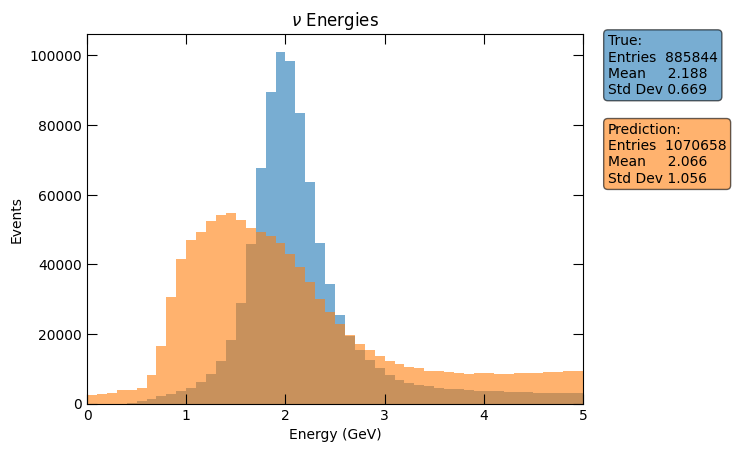

In [90]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 50 + 1)

*_, bc = ax.hist(df_big_truth[df_big_truth > 0], bins=bins_conf, alpha=0.6)
plot_info(df_big_truth[(df_big_truth > 0) & (df_big_truth < 5)], bc, 'True')

*_, bc = ax.hist(s2_model_big_pred, bins=bins_conf, alpha=0.6)
plot_info(s2_model_big_pred[(s2_model_big_pred > 0) & (s2_model_big_pred < 5)], bc, 'Prediction')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
# ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

ax.set_title(r'$\nu$ Energies')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');
